# Module 05 Project Overview

The purpose of this project is to examine the relationship between testing of H1BAlc and hospital readmittance rates of patients with diabetes as a diagnosis. The model will attempt to predict which patients are likely to be readmitted for complications and categorized as being hospitalized within a month, more than a month from most recent discharge, and never. This model and similar models can change when testing is administered, possibly resulting in earlier diagnosis and preventative measures to be taken during the initial treatment period to avoid readmittance, lowering healthcare costs for both patient and hospital. 

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns

In [2]:
raw_df = pd.read_csv("diabetes_data.csv")
df = pd.read_csv("diabetes_data.csv")

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
len(df)

101766

In [5]:
#df.profile_report()

## Preprocessing

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df = df.drop('weight', axis=1) #Dropping weight since too few rows have actual values
df = df.drop('payer_code', axis=1) #Unnecessary for classification task
df = df.drop('citoglipton', axis=1) #Rejected - all "no"
df = df.drop('examide', axis=1) #Rejected - all "no"

Because the medical specialty of the service provider could have influence on whether the H1bAlc test was performed, missing values will be replace with 'Unknown'.

In [8]:
df['medical_specialty'].replace(to_replace='?', value='Unknown', inplace=True)

In [9]:
df.race.value_counts(normalize=True)

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

The following code replaces missing values in the race column with a random choice aligned with the probabilities of all other race options.

In [10]:
df['race'] = df['race'].apply(lambda x: np.random.choice(['Caucasian', 'AfricanAmerican','Hispanic', 'Other', 'Asian'], p=[0.76, 0.19, 0.02, 0.02, 0.01]) if x == '?' else x)

In [11]:
df.race.value_counts(normalize=True) #Confirming appropriate distribution

Caucasian          0.764951
AfricanAmerican    0.192884
Hispanic           0.020459
Other              0.015172
Asian              0.006535
Name: race, dtype: float64

In [12]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [13]:
df = df[df.gender != 'Unknown/Invalid'] #dropping the three unknown gender rows

In [14]:
for col in df.columns:
    print(col, df[col].unique(), '\n\n')

encounter_id [  2278392    149190     64410 ... 443854148 443857166 443867222] 


patient_nbr [  8222157  55629189  86047875 ... 140199494 120975314 175429310] 


race ['Caucasian' 'AfricanAmerican' 'Other' 'Hispanic' 'Asian'] 


gender ['Female' 'Male'] 


age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)'] 


admission_type_id [6 1 2 3 4 5 8 7] 


discharge_disposition_id [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27] 


admission_source_id [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13] 


time_in_hospital [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14] 


medical_specialty ['Pediatrics-Endocrinology' 'Unknown' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'

diabetesMed ['No' 'Yes'] 


readmitted ['NO' '>30' '<30'] 




Due to my lack of medical knowledge, the following function will take in a column of ICD9 codes, process the values, and separate into dataframes that correspond with the diagnosis category, and finally concatenate back into the full dataframe. This will help my understanding of the data. 

In [15]:
def diagnose(x):
    if (x >= 390) and (x <= 459) or (x == 785):
        return 'circulatory'
    elif (x >= 460) and (x <= 519) or (x == 786):
        return'respiratory'
    elif (x >= 520) and (x <= 579) or (x == 787):
        return 'digestive'
    elif (x >= 250) and (x <= 251):
        return 'diabetes'
    elif (x >= 800) and (x <= 999):
        return 'injury_poisoning'
    elif (x >= 710) and (x <= 739): 
        return 'musculoskeletal'
    elif (x >= 580) and (x <= 629) or (x == 788): 
        return 'genitourinary'
    
    elif (x >= 140) and (x <= 239): 
         return'neoplasms'
    
    elif (x >= 240) and (x <= 279): 
         return'endocrine_nutrition_metabolic'
    
    elif (x >= 680) and (x <= 709) or (x == 782): 
         return'skin_disease'
    
    elif (x >= 1) and (x <= 139): 
         return'infection_parasites'
    
    elif (x >= 290) and (x <= 319): 
        return 'mental'
    
    elif (x >= 0) and (x <1) or (x == 786): 
        return 'external_injury'
    
    elif (x >= 280) and (x <= 289):
        return 'blood'
    
    elif (x >= 320) and (x <= 359): 
        return 'nervous'
    
    elif (x >= 630) and (x <= 679):
        return 'pregnancy_childbirth'
    
    elif (x >= 360) and (x <= 389): 
        return 'sensory'
    
    elif (x >= 740) and (x <= 759):
        return 'congenital'
    
    elif (x >= 790) and (x <= 799) or (x == 780) or (x == 781) or (x == 784) or (x == 783):
        return 'other'
    else:
        return x

In [16]:
for col in ['diag_1', 'diag_2', 'diag_3']: 
    df[col] = [x.replace('V', "0.") for x in df[col]]
    df[col] = [x.replace('E', '0.') for x in df[col]]
    df[col] = [x.replace('?', '0') for x in df[col]]
    df[col] = df[col].astype(float)

In [17]:
df.diag_1 = df.diag_1.apply(diagnose)
df.diag_2 = df.diag_2.apply(diagnose)
df.diag_3 = df.diag_3.apply(diagnose)

In [18]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(col, df[col].unique(), '\n\n')

diag_1 ['diabetes' 'endocrine_nutrition_metabolic' 'pregnancy_childbirth'
 'infection_parasites' 'neoplasms' 'circulatory' 'respiratory'
 'injury_poisoning' 'skin_disease' 'musculoskeletal' 'digestive'
 'external_injury' 'genitourinary' 'mental' 'other' 'nervous' 'blood'
 789.0 'sensory' 'congenital'] 


diag_2 ['external_injury' 'diabetes' 'neoplasms' 'circulatory' 'respiratory'
 'blood' 'injury_poisoning' 'musculoskeletal' 'genitourinary'
 'infection_parasites' 'endocrine_nutrition_metabolic' 'digestive'
 'skin_disease' 'nervous' 'other' 'mental' 'pregnancy_childbirth'
 'congenital' 789.0 'sensory'] 


diag_3 ['external_injury' 'endocrine_nutrition_metabolic' 'circulatory'
 'diabetes' 'infection_parasites' 'respiratory' 'injury_poisoning'
 'neoplasms' 'genitourinary' 'musculoskeletal' 'other' 'digestive'
 'skin_disease' 'mental' 789.0 'congenital' 'nervous' 'sensory'
 'pregnancy_childbirth' 'blood'] 




Keeping in line with the research paper, for patients who have had multiple encounters, each encounter past the first has been removed as they cannot be deemed statistically independent. 

In [19]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

## Exploratory Data Analysis

In [20]:
target = df.readmitted
features = df.drop('readmitted', axis=1)

In [21]:
#df.profile_report()

Since the problem we're trying to solve is classifying and predicting patients that received the H1BA1c hyperglycemia test and the likelihood that they will be readmitted for complications, we'll take a look at readmittance rates for those who have received and have not received the test. 

In [22]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [23]:
tested = df.loc[df.A1Cresult != 'None']
not_tested = df.loc[df.A1Cresult == 'None']

Female    38025
Male      33490
Name: gender, dtype: int64


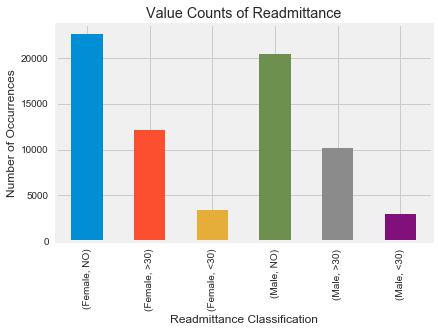

In [24]:
df.groupby(df.gender).readmitted.value_counts().plot(kind='bar')
plt.title('Value Counts of Readmittance')
plt.xlabel('Readmittance Classification')
plt.ylabel('Number of Occurrences');
print(df.gender.value_counts())

More women are admitted than men, and both men and women are more often not readmitted, and lease likely to be readmitted within the thirty days following discharge. 

Female    38025
Male      33490
Name: gender, dtype: int64


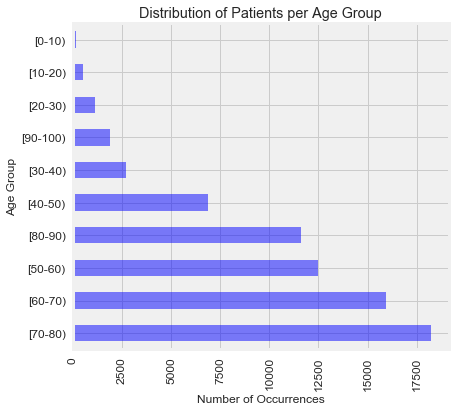

In [25]:
fig = plt.figure(figsize=(6,6))

df.age.value_counts().plot(kind='barh', color='blue', alpha=.5)
plt.title('Distribution of Patients per Age Group')
plt.ylabel('Age Group')
plt.xticks(rotation='vertical', size='large')
plt.yticks(size='large')
plt.xlabel('Number of Occurrences');
print(df.gender.value_counts())

Female    38025
Male      33490
Name: gender, dtype: int64


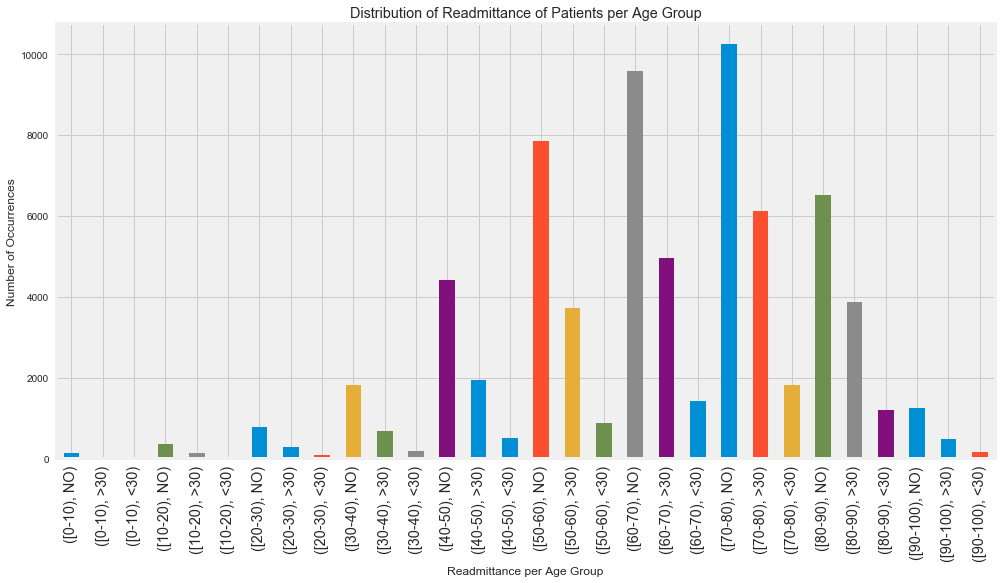

In [26]:
fig = plt.figure(figsize=(15,8))
df.groupby(df.age).readmitted.value_counts().plot(kind='bar')
plt.title('Distribution of Readmittance of Patients per Age Group')
plt.xlabel('Readmittance per Age Group')
plt.xticks(rotation='vertical', size='x-large')
plt.ylabel('Number of Occurrences');
print(df.gender.value_counts())

In [27]:
tested.diag_1.unique()

array(['circulatory', 'genitourinary', 'diabetes', 'digestive',
       'injury_poisoning', 'nervous', 'endocrine_nutrition_metabolic',
       'mental', 'neoplasms', 'respiratory', 'musculoskeletal', 'other',
       'pregnancy_childbirth', 'skin_disease', 789.0, 'external_injury',
       'infection_parasites', 'sensory', 'blood', 'congenital'],
      dtype=object)

In [28]:
diabetes = tested.loc[tested['diag_1']=='diabetes'] 
for x in df.A1Cresult.unique():
    print(f' A1C Result: {x}\n\n') 
    print(diabetes.loc[df.A1Cresult == x].readmitted.value_counts(normalize=True)*100)

 A1C Result: None


Series([], Name: readmitted, dtype: float64)
 A1C Result: >7


NO     55.555556
>30    32.367150
<30    12.077295
Name: readmitted, dtype: float64
 A1C Result: >8


NO     66.098361
>30    27.934426
<30     5.967213
Name: readmitted, dtype: float64
 A1C Result: Norm


NO     58.017493
>30    32.361516
<30     9.620991
Name: readmitted, dtype: float64


In [29]:
diabetes2 = tested.loc[tested['diag_2']=='diabetes'] 
diabetes2.loc[diabetes2['A1Cresult'] != 'None'].readmitted.value_counts(normalize=True)*100

NO     63.397129
>30    28.803828
<30     7.799043
Name: readmitted, dtype: float64

In [30]:
tested.groupby('diag_1').A1Cresult.value_counts(normalize=True)*100

diag_1                         A1Cresult
789.0                          >8           51.851852
                               Norm         27.777778
                               >7           20.370370
blood                          Norm         52.857143
                               >8           31.428571
                               >7           15.714286
circulatory                    >8           46.636012
                               Norm         29.235237
                               >7           24.128751
congenital                     >8           57.142857
                               >7           28.571429
                               Norm         14.285714
diabetes                       >8           73.493976
                               Norm         16.530120
                               >7            9.975904
digestive                      >8           42.216981
                               Norm         32.900943
                               >7        

## Preliminary Model